In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
#from helper_functions.invertible_neural_network_positive import InvertibleNetworkSurrogate

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score#,mean_absolute_percentage_error

In [2]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [3]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [4]:
# wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [5]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

### Import test data

In [6]:
test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1.h5'

In [7]:
dvar_test = pd.read_hdf(test_datafile, key = 'dvar')
qoi_test = pd.read_hdf(test_datafile, key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [8]:
qoi_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
1      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
2      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
3      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
4      6.868667  6.848986  6.828374  6.806935  6.784763  6.761942  6.738547   
...         ...       ...       ...       ...       ...       ...       ...   
19464  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
19465  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
19466  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
19467  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
19468  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.343187  2.246660  2.150146  ...  0.032973  0.030442  0.027918   
1      0.820055  0.677661  0.542517  ...  0.018595  0.017020  0.015502   
2      4.427529  4.389708  4.349729  ...  0.033449  0.033608  0.033061   
3      4.476688  4.386768  4.298978  ...  0.034360  0.031700  0.029060   
4      6.714646  6.690300  6.665563  ...  0.043713  0.039338  0.035179   
...         ...       ...       ...  ...       ...       ...       ...   
19464  8.557358  8.496452  8.435355  ...  0.061744  0.055834  0.050172   
19465  2.331944  2.303737  2.273986  ...  0.058451  0.053110  0.047927   
19466  2.778518  2.680291  2.583919  ...  0.030253  0.028088  0.025911   
19467  7.956617  7.857872  7.762334  ...  0.033731  0.030741  0.027837   
19468  5.152917  5.109587  5.066588  ...  0.049745  0.044876  0.040226   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.025410  0.022931  0.020492  0.018108  0.015795  0.013569  0.011450  
1      0.014041  0.012637  0.011287  0.009990  0.008745  0.007557  0.006427  
2      0.031898  0.030215  0.028111  0.025682  0.023025  0.020230  0.017385  
3      0.026447  0.023871  0.021344  0.018878  0.016487  0.014186  0.011993  
4      0.031238  0.027520  0.024026  0.020760  0.017724  0.014920  0.012352  
...         ...       ...       ...       ...       ...       ...       ...  
19464  0.044766  0.039624  0.034753  0.030163  0.025863  0.021862  0.018169  
19465  0.042922  0.038115  0.033522  0.029164  0.025055  0.021213  0.017653  
19466  0.023727  0.021547  0.019380  0.017238  0.015136  0.013091  0.011119  
19467  0.025027  0.022317  0.019717  0.017235  0.014880  0.012662  0.010591  
19468  0.035801  0.031608  0.027653  0.023941  0.020478  0.017269  0.014319  

[19469 rows x 304 columns]

In [9]:
# Process F11 and PPF for the plots --> np.exp(F11)

F11_list = [x for x in qoi_test.columns if 'F11' in x]
PPF_list = [x for x in qoi_test.columns if 'PPF' in x]

qoi_test_plot = qoi_test.copy()
qoi_test_plot[F11_list] = np.exp(qoi_test_plot[F11_list])
qoi_test_plot[PPF_list] = (qoi_test_plot[PPF_list])

In [10]:
# Process the state parameters to get back "normal" values --> np.exp(V), np.axp(R), np.exp(GSD)+1, np.exp(n)+1.33, np.exp(k)

dvar_test_plot = dvar_test.copy()
dvar_test_plot['Vtot'] = np.exp(dvar_test['Vtot'])
dvar_test_plot['RmedianV'] = np.exp(dvar_test['RmedianV'])
dvar_test_plot['GSD'] = np.exp(dvar_test['GSD'])+1
dvar_test_plot['n'] = np.exp(dvar_test['n'])+1.33
dvar_test_plot['k'] = np.exp(dvar_test['k'])

### Load the model to test

In [11]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

# Model directory
directory = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv5'
model_dir = directory + '/models'

# Plot directory (subdirectory of the model)
plot_dir = model_dir +'/plots/test_data_original_1/'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [12]:
custom_objects = {'AdjustedRSquared':AdjustedRSquared}

kwargs = {'custom_objects':custom_objects, 'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

#### Forward prediction

In [13]:
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
dt = (end-start)#/len(dvar_test)

qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)


print('Time for the forward prediction: %i s' %dt)

Time for the forward prediction: 2 s


In [14]:
# Process the data for the plots --> np.exp(F11)

F11_list = [x for x in qoi_pred_fw.columns if 'F11' in x]
PPF_list = [x for x in qoi_pred_fw.columns if 'PPF' in x]

qoi_pred_fw_plot = qoi_pred_fw.copy()
qoi_pred_fw_plot[F11_list] = np.exp(qoi_pred_fw_plot[F11_list])
qoi_pred_fw_plot[PPF_list] = (qoi_pred_fw_plot[PPF_list])

#### Inverse prediction

In [15]:
start = time.time()
dvar_pred_iv_original = surr.sample_n_tries(qoi_test.values, batch_size = 8, n_tries = 1)
end = time.time()
dt = (end-start)#/len(dvar_test)

dvar_pred_iv = pd.DataFrame(data = dvar_pred_iv_original, columns = dvar_test.columns)

print('Time for the inverse prediction: %i s' %dt)

Time for the inverse prediction: 24 s


In [16]:
# Process the data to get back "normal" values --> np.exp(V), np.axp(R), np.exp(GSD)+1, np.exp(n)+1.33, np.exp(k)

dvar_pred_iv_plot = dvar_pred_iv.copy()
dvar_pred_iv_plot['Vtot'] = np.exp(dvar_pred_iv_plot['Vtot'])
dvar_pred_iv_plot['RmedianV'] = np.exp(dvar_pred_iv_plot['RmedianV'])
dvar_pred_iv_plot['GSD'] = np.exp(dvar_pred_iv_plot['GSD'])+1
dvar_pred_iv_plot['n'] = np.exp(dvar_pred_iv_plot['n'])+1.33
dvar_pred_iv_plot['k'] = np.exp(dvar_pred_iv_plot['k'])

### Metrics forward step

In [17]:
qoi_test_copy = qoi_test_plot.copy()
qoi_pred_fw_copy  = qoi_pred_fw_plot.copy()

#### 1. R2 - forward step

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$

In [18]:
# Define which metric to use
metric_fw = RSquaredSeparated() # separated means that it is calculated for each variable

r2_fw = metric_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_fw = pd.Series(data=r2_fw, index=qoi_columns)
r2_fw = np.round(r2_fw, decimals=2)
r2_fw = pd.DataFrame(r2_fw).T

print('Forward model: R2_min = %.2f ; R2_max = %.2f ; R2_mean = %.2f '
      % (r2_fw.mean(axis=1), min(r2_fw.min()), max(r2_fw.max())))

Forward model: R2_min = -125.89 ; R2_max = -37062.12 ; R2_mean = 1.00 


In [19]:
# List the 10 points with the lowest R2
r2_fw.sort_values(by=r2_fw.index[0], axis=1, ascending=True).iloc[:, :10]

F11_25   F11_49  F11_168  F11_18  F11_13  F11_59  F11_35  F11_101  \
0 -37062.12 -1459.67   -14.83  -11.16   -2.82   -2.11   -0.66    -0.18   

   F11_43  F11_132  
0   -0.02     0.12

#### 2. Adjusted R2 - forward step

adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [20]:
# Define which metric to use
metric2_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])

r2_adj_fw = metric2_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T

print('Forward model: R2adj_mean = %.2f  ;  R2adj_min = %.2f  ;  R2adj_max = %.2f '
      % (r2_adj_fw.mean(axis=1), min(r2_adj_fw.min()), max(r2_adj_fw.max())))

Forward model: R2adj_mean = -127.90  ;  R2adj_min = -37650.05  ;  R2adj_max = 1.00 


In [21]:
# List the 10 points with the lowest adjR2
r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis=1, ascending=True).iloc[:, :10]

F11_25   F11_49  F11_168  F11_18  F11_13  F11_59  F11_35  F11_101  \
0 -37650.05 -1482.84   -15.08  -11.35   -2.88   -2.16   -0.68     -0.2   

   F11_43  F11_132  
0   -0.03      0.1

#### 3. Absolute error - forward step

absolute_error = $|y_{true}-y_{pred}|$

In [22]:
abs_error_fw = np.abs(qoi_test_copy - qoi_pred_fw_copy)

In [23]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [24]:
abs_error_table_fw.sort_values(by=abs_error_table_fw.index[3], axis=1, ascending=False).iloc[:, :10]

F11_10   F11_11   F11_14   F11_12   F11_18   F11_16   F11_13   F11_19  \
50%     6.30     5.79     4.44     4.81     3.10     3.32     3.97     2.15   
75%    60.26    50.91    39.79    43.45    29.20    28.97    32.03    20.62   
90%   287.26   255.31   197.36   193.98   151.77   141.47   141.28   109.39   
95%   624.22   593.53   468.35   383.31   354.80   320.64   307.42   270.68   
99%  2128.21  1920.66  1945.48  1139.34  1509.80  1166.62  1362.59  1110.17   

     F11_15  F11_20  
50%    2.69    1.71  
75%   21.68   15.77  
90%   96.32   84.76  
95%  211.41  205.57  
99%  855.93  936.50

In [25]:
abs_error_table_fw_F11 = abs_error_table_fw[F11_list]
print('Absolute error F11:')
print(abs_error_table_fw_F11.max(axis = 1))
print('\n')

abs_error_table_fw_PPF = abs_error_table_fw[PPF_list]
print('Absolute error PPF:')
print(abs_error_table_fw_PPF.max(axis = 1))
print('\n')


Absolute error F11:
50%       6.30
75%      60.26
90%     287.26
95%     624.22
99%    2128.21
dtype: float64


Absolute error PPF:
50%    0.01
75%    0.01
90%    0.02
95%    0.03
99%    0.08
dtype: float64




#### 4. Relative error - forward step

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

***be careful, if $y_{true}$ is very small***


In [26]:
rel_error_fw = abs_error_fw / (qoi_test_copy) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [27]:
rel_error_table_fw =  np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [28]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis=1, ascending=False).iloc[:, :10]

PPF_10  F11_144  F11_164  PPF_11  F11_59  F11_12  PPF_14  F11_10  PPF_12  \
50%    4.22    20.47     9.91    2.78    6.53    5.92    2.85    6.13    2.56   
75%   13.34    34.43    22.45    6.24   10.97   13.55    5.93   13.34    5.49   
90%   35.79    53.79    39.93   21.23   23.65   27.25   16.91   25.72   15.93   
95%   94.39    87.65    53.14   47.92   45.43   37.90   37.14   35.60   34.50   
99%  781.40   180.70    95.09  263.27  135.35   67.98  229.62   61.97  209.64   

     F11_14  
50%    7.29  
75%   13.35  
90%   23.92  
95%   33.86  
99%   77.89

In [29]:
rel_error_table_fw_F11 = rel_error_table_fw[F11_list]
print('Relative error F11:')
print(rel_error_table_fw_F11.max(axis=1))
print('\n')

rel_error_table_fw_PPF = rel_error_table_fw[PPF_list]
print('Relative error PPF:')
print(rel_error_table_fw_PPF.max(axis=1))

Relative error F11:
50%     20.47
75%     34.43
90%     53.79
95%     87.65
99%    180.70
dtype: float64


Relative error PPF:
50%      4.22
75%     13.34
90%     35.79
95%     94.39
99%    781.40
dtype: float64


#### 5. wMAPE - forward step

In [30]:
wMAPE_fw = wmape(qoi_test_copy, qoi_pred_fw_copy)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T

In [31]:
wMAPE_fw.sort_values(by=wMAPE_fw.index[0], axis=1, ascending=False).iloc[:, :10]

F11_25      F11_49    F11_144     F11_59     F11_18    F11_168  \
0  374.289925  110.636228  34.080613  31.109205  21.848872  19.499139   

      F11_63    F11_164     F11_35    F11_138  
0  18.323896  17.510936  14.723564  13.971289

In [32]:
print('Mean wMAP value for F11: %.3f' % wMAPE_fw[F11_list].mean().mean())

Mean wMAP value for F11: 11.770


In [33]:
print('Mean wMAP value for PPF: %.3f' % wMAPE_fw[PPF_list].mean().mean())

Mean wMAP value for PPF: 3.076


### Metrics inverse step

In [34]:
dvar_test_copy = dvar_test.copy()
dvar_pred_iv_copy = dvar_pred_iv.copy()

#### 1. R2 - inverse step

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$

In [35]:
# Define which metric to use
metric_iv = RSquaredSeparated() # separated means that it is calculated for each variable

r2_iv = metric_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_iv = pd.Series(data=r2_iv, index=dvar_columns)
r2_iv = np.round(r2_iv, decimals=2)
r2_iv = pd.DataFrame(r2_iv).T

print('Inverse model: R2_mean = %.2f ; R2_min = %.2f ; R2_max = %.2f '
      % (r2_iv.mean(axis=1), min(r2_iv.min()), max(r2_iv.max())))

Inverse model: R2_mean = 0.99 ; R2_min = 0.97 ; R2_max = 1.00 


In [36]:
# List the 10 points with the lowest R2
r2_iv.sort_values(by=r2_iv.index[0], axis=1, ascending=True)

n   GSD     k  Vtot  RmedianV
0  0.97  0.99  0.99   1.0       1.0

#### 2. Adjusted R2 - inverse step

adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [37]:
# Define which metric to use
metric2_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_iv = metric2_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T

print('Inverse model: R2adj_mean = %.2f  ;  R2adj_min = %.2f  ;  R2adj_max = %.2f '
      % (r2_adj_iv.mean(axis=1), min(r2_adj_iv.min()), max(r2_adj_iv.max())))

Inverse model: R2adj_mean = 0.99  ;  R2adj_min = 0.97  ;  R2adj_max = 1.00 


In [38]:
# List the 10 points with the lowest adjR2
r2_adj_iv.sort_values(by=r2_adj_iv.index[0], axis=1, ascending=True).iloc[:, :10]

n   GSD     k  Vtot  RmedianV
0  0.97  0.99  0.99   1.0       1.0

#### 3. Absolute error - inverse step

absolute_error = $|y_{true}-y_{pred}|$

In [39]:
abs_error_iv = np.abs(dvar_test_copy - dvar_pred_iv_copy)

In [40]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [41]:
abs_error_table_iv.sort_values(by=abs_error_table_iv.index[3], axis=1, ascending=False)

n     k   GSD  Vtot  RmedianV
50%  0.03  0.03  0.02  0.02      0.01
75%  0.06  0.05  0.03  0.04      0.03
90%  0.11  0.09  0.06  0.07      0.05
95%  0.19  0.13  0.10  0.09      0.07
99%  0.67  0.36  0.25  0.18      0.12

In [42]:
print('Inverse model: mean abs. error \n')
print(abs_error_iv.mean())

Inverse model: mean abs. error 

Vtot        0.031961
RmedianV    0.022215
GSD         0.030356
n           0.063901
k           0.045527
dtype: float64


In [43]:
print('Inverse model: max abs. error \n')
print(abs_error_iv.max())

Inverse model: max abs. error 

Vtot        1.410395
RmedianV    0.606112
GSD         1.446649
n           8.405273
k           4.795267
dtype: float64


#### 4. Relative error - inverse step

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

***be careful, if $y_{true}$ is very small***


In [44]:
rel_error_iv = abs_error_iv / (dvar_test_copy) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [45]:
rel_error_table_iv =  np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [46]:
rel_error_table_iv.sort_values(by=rel_error_table_iv.index[3], axis=1, ascending=False)

n       k     GSD   Vtot  RmedianV
50%    7.16    5.37    3.87   0.55      0.23
75%   16.85   12.17    9.16   1.43      0.43
90%   41.09   30.12   24.10   4.35      0.69
95%   83.33   59.28   48.77   8.98      0.92
99%  390.78  295.93  253.46  42.19      1.72

In [47]:
print('Inverse model: mean rel error in % \n')
print(rel_error_iv.mean())

Inverse model: mean rel error in % 

Vtot         4.536859
RmedianV     0.328223
GSD         23.624857
n           41.259659
k           32.882066
dtype: float64


In [48]:
print('Inverse model: max rel error in % \n')
print(rel_error_iv.max())

Inverse model: max rel error in % 

Vtot        11850.150471
RmedianV        7.430316
GSD         35318.474965
n           41358.967973
k           71548.683997
dtype: float64


#### 5. wMAPE - inverse step

In [49]:
wMAPE_iv = wmape(dvar_test_copy, dvar_pred_iv_copy)
wMAPE_iv = pd.DataFrame(wMAPE_iv).T

In [50]:
wMAPE_iv.sort_values(by=wMAPE_iv.index[0], axis=1, ascending=False)

n        k       GSD     Vtot  RmedianV
0  8.891078  6.61235  4.989034  0.75589  0.339256

In [51]:
print('Mean wMAP value for F11: %.3f' % wMAPE_fw[F11_list].mean().mean())

Mean wMAP value for F11: 11.770


In [52]:
print('Mean wMAP value for PPF: %.3f' % wMAPE_fw[PPF_list].mean().mean())

Mean wMAP value for PPF: 3.076


### Performance summary

In [53]:
performance = pd.DataFrame(columns = ['F11','PPF','Vtot','RmedianV','GSD','n','k'])

performance.loc['r2']= [r2_fw[F11_list].mean(axis=1)[0],
                        r2_fw[PPF_list].mean(axis=1)[0],
                        r2_iv['Vtot'][0],
                        r2_iv['RmedianV'][0],
                        r2_iv['GSD'][0],
                        r2_iv['n'][0],
                        r2_iv['k'][0]
                       ]

#performance.loc['R2adj']= [r2_adj_fw[F11_list].mean(axis=1)[0],
#                            r2_adj_fw[PPF_list].mean(axis=1)[0],
#                            r2_adj_iv['Vtot'][0],
#                            r2_adj_iv['RmedianV'][0],
#                            r2_adj_iv['GSD'][0],
#                            r2_adj_iv['n'][0],
#                            r2_adj_iv['k'][0]
#                           ]
performance.loc['max_abs_err_90%']= [abs_error_table_fw_F11.max(axis = 1)['90%'],
                                     abs_error_table_fw_PPF.max(axis = 1)['90%'],
                                     abs_error_table_iv.loc['90%']['Vtot'],
                                     abs_error_table_iv.loc['90%']['RmedianV'],
                                     abs_error_table_iv.loc['90%']['GSD'],
                                     abs_error_table_iv.loc['90%']['n'],
                                     abs_error_table_iv.loc['90%']['k']
                                    ]


performance.loc['max_abs_err_95%']= [abs_error_table_fw_F11.max(axis = 1)['95%'],
                                     abs_error_table_fw_PPF.max(axis = 1)['95%'],
                                     abs_error_table_iv.loc['95%']['Vtot'],
                                     abs_error_table_iv.loc['95%']['RmedianV'],
                                     abs_error_table_iv.loc['95%']['GSD'],
                                     abs_error_table_iv.loc['95%']['n'],
                                     abs_error_table_iv.loc['95%']['k']
                                    ]

performance.loc['max_rel_err_90%']= [rel_error_table_fw_F11.max(axis = 1)['90%'],
                                     rel_error_table_fw_PPF.max(axis = 1)['90%'],
                                     rel_error_table_iv.loc['90%']['Vtot'],
                                     rel_error_table_iv.loc['90%']['RmedianV'],
                                     rel_error_table_iv.loc['90%']['GSD'],
                                     rel_error_table_iv.loc['90%']['n'],
                                     rel_error_table_iv.loc['90%']['k']
                                    ]


performance.loc['max_rel_err_95%']= [rel_error_table_fw_F11.max(axis = 1)['95%'],
                                     rel_error_table_fw_PPF.max(axis = 1)['95%'],
                                     rel_error_table_iv.loc['95%']['Vtot'],
                                     rel_error_table_iv.loc['95%']['RmedianV'],
                                     rel_error_table_iv.loc['95%']['GSD'],
                                     rel_error_table_iv.loc['95%']['n'],
                                     rel_error_table_iv.loc['95%']['k']
                                    ]

performance.loc['wMAPE']= [wMAPE_fw[F11_list].mean().mean(),
                           wMAPE_fw[PPF_list].mean().mean(),
                           wMAPE_iv['Vtot'][0],
                           wMAPE_iv['RmedianV'][0],
                           wMAPE_iv['GSD'][0],
                           wMAPE_iv['n'][0],
                           wMAPE_iv['k'][0]
                          ]

#performance.loc['rel_err_max_95%']= [rel_error_table_fw_F11.max(axis = 1)['95%'],rel_error_table_fw_PPF.max(axis = 1)['95%'],rel_error_table_iv.loc['95%'].values[0],rel_error_table_iv.loc['95%'].values[1],rel_error_table_iv.loc['95%'].values[2],rel_error_table_iv.loc['95%'].values[3],rel_error_table_iv.loc['95%'].values[4]]
#performance.loc['wmape']= [,,,,,,]



In [54]:
performance = performance.round(decimals = 2)
performance

F11    PPF  Vtot  RmedianV    GSD      n      k
r2              -252.75   0.98  1.00      1.00   0.99   0.97   0.99
max_abs_err_90%  287.26   0.02  0.07      0.05   0.06   0.11   0.09
max_abs_err_95%  624.22   0.03  0.09      0.07   0.10   0.19   0.13
max_rel_err_90%   53.79  35.79  4.35      0.69  24.10  41.09  30.12
max_rel_err_95%   87.65  94.39  8.98      0.92  48.77  83.33  59.28
wMAPE             11.77   3.08  0.76      0.34   4.99   8.89   6.61

In [55]:
performance.to_csv(f'{plot_dir}/iv_error_df.csv')

### Plot for validation vs predicted values

In [56]:
index_list = [100, 1000, 10000]

In [57]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles_plot = np.concatenate([angles1, angles2])

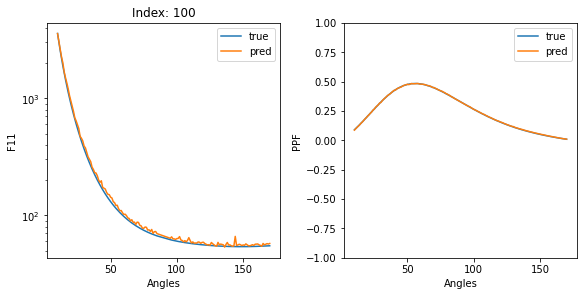

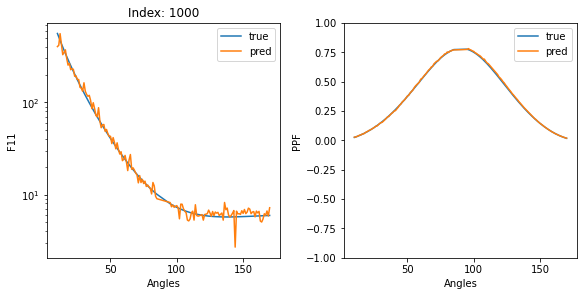

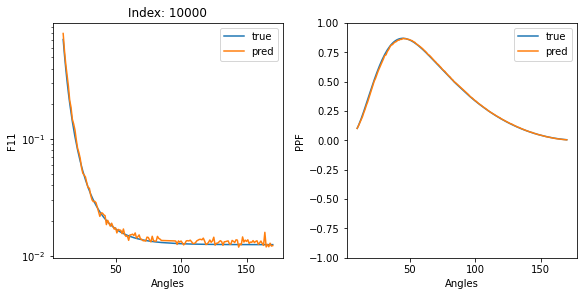

In [58]:
for idx in index_list:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

    axs[0].set_title('Index: %i' %idx)
    axs[0].plot(angles_plot, qoi_test_plot[F11_list].iloc[idx], c='C0', label = 'true')
    axs[0].plot(angles_plot, qoi_pred_fw_plot[F11_list].iloc[idx], c='C1', label = 'pred')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Angles')
    axs[0].set_ylabel('F11')
    axs[0].legend()
    axs[1].plot(angles_plot, qoi_test_plot[PPF_list].iloc[idx], c='C0', label = 'true')
    axs[1].plot(angles_plot, qoi_pred_fw_plot[PPF_list].iloc[idx], c='C1', label = 'pred')
    axs[1].set_ylim(-1, 1)
    axs[1].set_xlabel('Angles')
    axs[1].set_ylabel('PPF')
    axs[1].legend()
    fig.savefig(f'{plot_dir}/PF_PPF_pred_index_'+str(idx)+'.jpg')

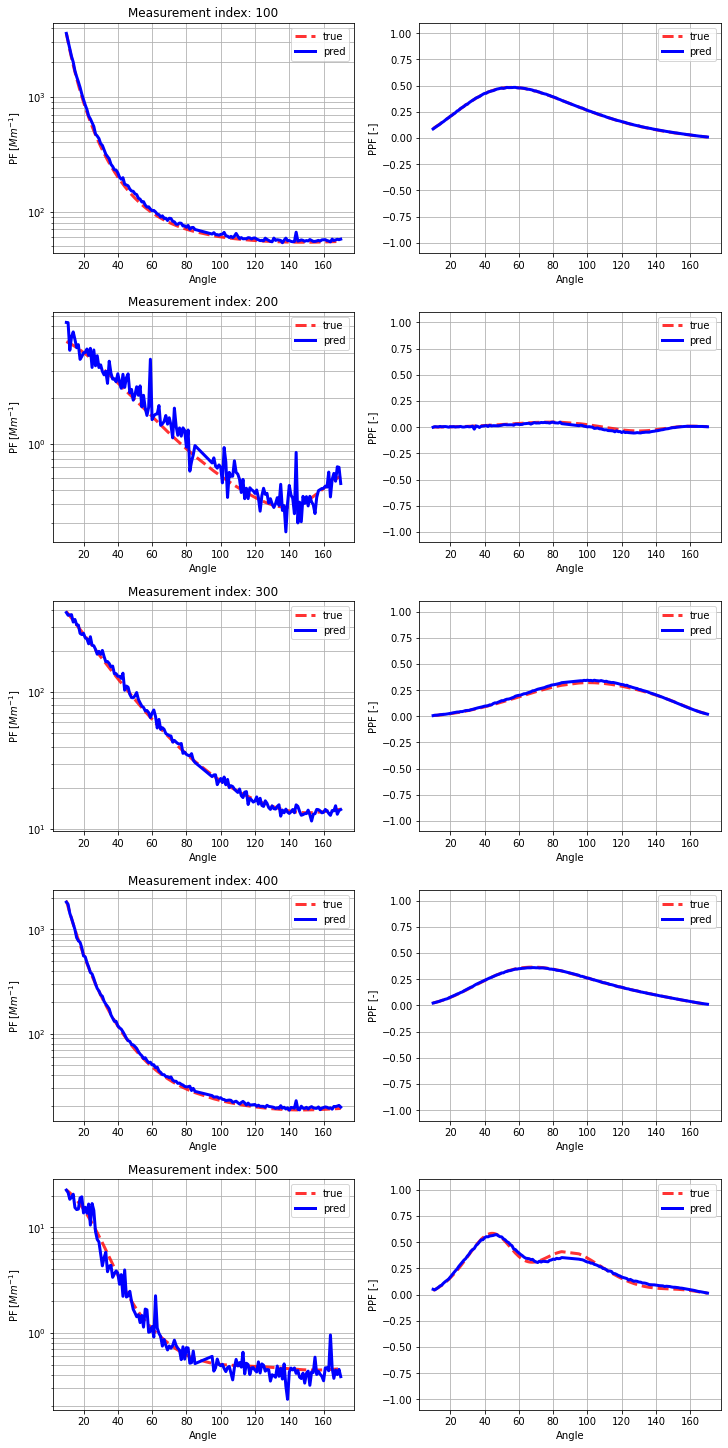

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(angles_plot, qoi_test_plot[F11_list].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
    pms_hdf_plot, = axs[nr,1].plot(angles_plot, qoi_test_plot[PPF_list].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(angles_plot, qoi_pred_fw_plot[F11_list].loc[index],ls = '-',lw ='3', c= 'b', label = 'pred')
    meas_hdf_plot, = axs[nr,1].plot(angles_plot, qoi_pred_fw_plot[PPF_list].loc[index],ls = '-',lw = '3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[nr,1].set_ylabel('PPF [-]')
    axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')

In [60]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [61]:
dvar_test_plot

Vtot     RmedianV       GSD         n         k
0         4.953045   447.099789  1.687354  2.622790  0.754203
1         9.853527  2953.110936  2.635387  2.087974  1.787399
2        27.700011   254.587570  1.044152  2.913697  1.101197
3        49.011526   519.446422  2.185569  2.364048  2.055679
4       441.427213   100.471110  2.205250  2.883629  1.983418
...            ...          ...       ...       ...       ...
19464  2902.889066   244.818462  2.048755  1.459021  0.468698
19465     3.793219   204.348275  1.206468  1.562014  1.081841
19466     8.990683   528.078164  1.949690  2.689447  1.873984
19467  2367.063858   780.091790  2.555797  2.806807  0.538075
19468    84.401659   168.632644  2.579873  2.563342  1.104086

[19469 rows x 5 columns]

In [62]:
dvar_test_plot['DmedianV']=dvar_test_plot['RmedianV']*2*1e-3 #[um]
dvar_test_plot['DmedianN']=(np.exp(np.log(dvar_test_plot['DmedianV']) - (3*np.log(dvar_test_plot['GSD'])**2))) *1e3   #[nm]
dvar_test_plot['Ntot'] = 6 / np.pi * dvar_test_plot['Vtot']*1e9 / (np.exp((3*np.log(dvar_test_plot['DmedianN'])) + (4.5*np.log(dvar_test_plot['GSD'])**2))) # [cm^-3]
 

In [63]:
dvar_pred_iv_plot

Vtot     RmedianV       GSD         n         k
0         4.777262   444.683791  1.658671  2.643024  0.779021
1         9.823367  2942.122025  2.603252  2.072588  1.744692
2        29.446904   256.630820  1.039696  2.912571  0.936840
3        47.927710   525.357345  2.207778  2.383771  2.053474
4       424.186615   100.659059  2.142477  2.891122  1.990787
...            ...          ...       ...       ...       ...
19464  3124.317066   232.760079  1.989423  1.444134  0.434258
19465     3.588770   206.696188  1.210208  1.538796  1.132106
19466     8.706229   524.872463  1.941149  2.712003  1.980160
19467  2304.235178   774.431277  2.521469  2.837700  0.557066
19468    84.563954   166.483821  2.582884  2.578088  1.088601

[19469 rows x 5 columns]

In [64]:
dvar_pred_iv_plot['DmedianV']=dvar_pred_iv_plot['RmedianV']*2*1e-3 #[um]
dvar_pred_iv_plot['DmedianN']=(np.exp(np.log(dvar_pred_iv_plot['DmedianV']) - (3*np.log(dvar_pred_iv_plot['GSD'])**2))) *1e3   #[nm]
dvar_pred_iv_plot['Ntot'] = 6 / np.pi * dvar_pred_iv_plot['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred_iv_plot['DmedianN'])) + (4.5*np.log(dvar_pred_iv_plot['GSD'])**2))) # [cm^-3]


In [65]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

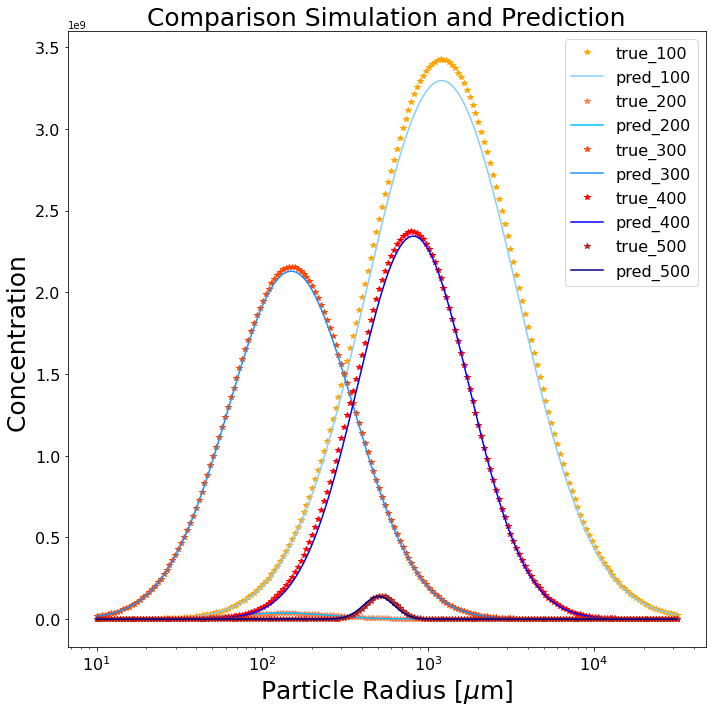

In [66]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']
j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test_plot['DmedianN'].loc[i], dvar_test_plot['GSD'].loc[i], dvar_test_plot['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred_iv_plot['DmedianN'].loc[i], dvar_pred_iv_plot['GSD'].loc[i], dvar_pred_iv_plot['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    

        #ax.legend(['Predicted test data', 'test data'], fontsize = 16)
    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')